# Benchmarks from hSVM paper
> Classification benchmarks on https://github.com/hhcho/hyplinear/tree/master/data


In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from scipy.io import loadmat

from src.hyperdt.tree import HyperbolicDecisionTreeClassifier
from src.hyperdt.conversions import convert


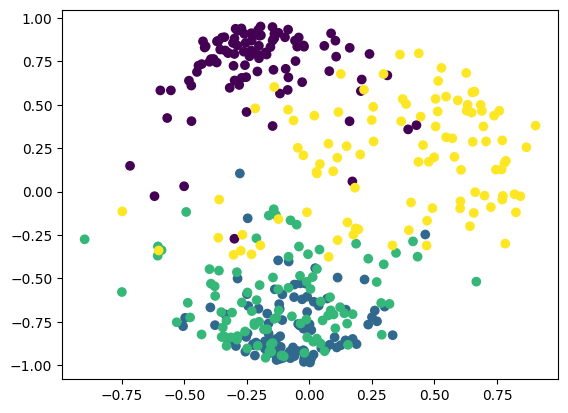

In [7]:
# Load .mat files from gaussian dir

matrix = loadmat("data/gaussian/data_001.mat")
X = matrix["B"]
y = matrix["label"]

plt.scatter(X[:, 0], X[:, 1], c=y)


In [24]:
# Benchmark: HDT vs. decision tree for all matrices

results = pd.DataFrame(
    columns=["HDT", "DT+hyperboloid", "DT+poincare", "DT+klein"]
)
tree_args = {
    "max_depth": 10,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
}
for file in tqdm(os.listdir("data/gaussian")):
    # Load data: this is in Poincare ball model
    matrix = loadmat(f"data/gaussian/{file}")
    X = matrix["B"]
    y = matrix["label"].ravel()

    # Split
    X_train_poi, X_test_poi, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Conversions
    X_train_hyp = convert(X_train_poi, "poincare", "hyperboloid")
    X_test_hyp = convert(X_test_poi, "poincare", "hyperboloid")
    X_train_klein = convert(X_train_poi, "poincare", "klein")
    X_test_klein = convert(X_test_poi, "poincare", "klein")

    # Train models
    hdt = HyperbolicDecisionTreeClassifier(**tree_args)
    hdt.fit(X_train_hyp, y_train)
    dt_hyp = DecisionTreeClassifier(**tree_args)
    dt_hyp.fit(X_train_hyp, y_train)
    dt_poi = DecisionTreeClassifier(**tree_args)
    dt_poi.fit(X_train_poi, y_train)
    dt_klein = DecisionTreeClassifier(**tree_args)
    dt_klein.fit(X_train_klein, y_train)

    # Evaluate
    results.loc[file] = [
        hdt.score(X_test_hyp, y_test),
        dt_hyp.score(X_test_hyp, y_test),
        dt_poi.score(X_test_poi, y_test),
        dt_klein.score(X_test_klein, y_test),
    ]

results.mean()

# HDT wins!

  0%|          | 0/100 [00:00<?, ?it/s]

HDT               0.752875
DT+hyperboloid    0.736875
DT+poincare       0.742500
DT+klein          0.749000
dtype: float64